# Homework 2 Solution Scripts

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # Plot styling

In [3]:
coordinates = pd.read_csv('coordinates_2_.csv')
demands = pd.read_csv('demand_2_.csv')
costs = pd.read_csv('costs_2_.csv')

A = np.asarray(coordinates) #first column= index of customer, second and third column= coordinates
H = np.abs(np.asarray(demands)) #first column= index of customer, second column= demand
C = np.abs(np.asarray(costs))   ##first column= index of facility, "i"th columns= cost of transporting 1 unit to the customer point "i"
A = A[:,1:]
H = H[:,1]
C = C[:,1:]  # index column is removed

In [4]:
def squaredDistSolforSingle(H=[], A=[], C=[], m=41):
    # If there is no assigned customer to facility, assign random location
    if A.size == 0:
        return np.random.randint(10,30),np.random.randint(10,30)
    facility_m = C[m] #cost vector of facility m: cost of transporting 1 unit from facility m to customer points
                                     #np.multiply(H[:,1],facility_m ->> output : element wise multiplier of cost vector and demand values
                                     #np.dot(H[:,1], facility_m) ->> output: total cost of transportation of demand
                                     #np.multiply(np.multiply(H[:,1],facility_m),A[:,1]) ->> weighted average of coordinates   
    x_v1_star = (np.sum(np.multiply(np.multiply(H,facility_m),A[:,0]))/np.dot(H, facility_m))
    x_v2_star = (np.sum(np.multiply(np.multiply(H,facility_m),A[:,1]))/np.dot(H, facility_m))
    
    return x_v1_star, x_v2_star

(20.61777028784148, 19.025248948862686, 344646.37089967413)

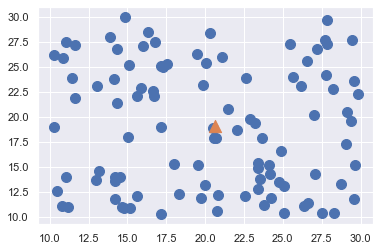

In [6]:
plt.scatter(A[:, 0], A[:, 1], s=np.size(A,axis=0))

m=41 # selected facility

x1, x2 = squaredDistSolforSingle(H,A,C,m)
plt.scatter(x1,x2, marker='^', s = 150)

# C[m,:]*H ->> cost for each consumer per unit distance
# np.sum((A-[x1,x2])**2, axis=1) ->> squared distances of each consumer to facility m
# objFuncValue ->> total of the multiplication of cost per dist and distances
objFuncValue = np.dot(C[m,:]*H,np.sum((A-[x1,x2])**2, axis=1))

x1, x2, objFuncValue


In [155]:
def Weiszfeld(H=[], A=[], C=[], m=41, eps = 0.001):
    cond = True
    itr = 0
    h = np.multiply(H, C[m])
    x_0 = (h @ A )/ np.sum(h)
    while cond:
        dj = np.sqrt(np.sum((A-x_0)**2, axis=1))
        x_1 = ((h / dj)  @ A) / np.sum((h / dj))
        cond = np.sqrt(np.sum((x_0-x_1)**2)) > eps
        x_0 = x_1
        itr += 1
    print('Total iterations: {0}'.format(itr))
    return x_1

Total iterations: 11


(20.916922080745955, 18.679128063345026)

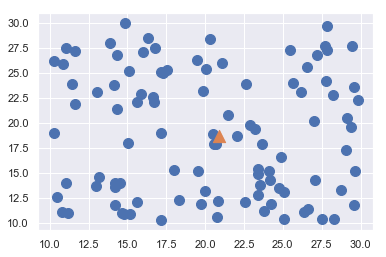

In [156]:
plt.scatter(A[:, 0], A[:, 1], s=np.size(A,axis=0))

x1, x2 = Weiszfeld(H,A,C,41)
plt.scatter(x1,x2, marker='^', s = 150)
x1, x2

In [5]:
def ALAHeuristics(H=[], A=[], C=[], seed=440): 
    cost_matrix = np.copy(C)
    for i in range(100):
        cost_matrix[:,i] = H[i]*C[:,i]
    # Initial step, random assignments of customers
    facility_customers = [[] for i in range(50)]
    facility_locations = np.zeros(shape=(50,2))
    np.random.seed(seed)
    customer_assignments = np.array([np.random.randint(0,50) for i in range(100)])
    for i in range(100):
        facility_customers[customer_assignments[i]].append(i)
    # Solving m single facility location problems and computing new objective value until no improvement
    old_objective = np.iinfo(np.int32).max
    count = 0
    while(True):
        count += 1
        new_objective = 0
        for i in range(50):
            x1, x2 = squaredDistSolforSingle(H[facility_customers[i]],A[facility_customers[i]],C[:,facility_customers[i]],i)
            facility_locations[i] = np.array([x1,x2])
        # Calculating total cost between each facility and customer
        total_cost_matrix = np.zeros((100,50))
        for i in range(100):
            coord_dif_matrix = facility_locations - A[i]
            # for squared euclidean distance
            distance_matrix = np.sum(coord_dif_matrix**2, axis=1)
            total_cost_matrix[i] = np.transpose(cost_matrix[:,i])*distance_matrix
        # New objective value calculation
        for i in range(50):
            facility_cost = np.sum(total_cost_matrix[facility_customers[i],i])
            new_objective += facility_cost
        print(new_objective)    
        if(new_objective>=old_objective):
            break
        old_objective = new_objective
        # Reassignment of customers according to distance to facilities
        facility_customers = [[] for i in range(50)]
        for i in range(100):
            nearest_facility = np.argmin(total_cost_matrix[i]) # index of minimum value
            facility_customers[nearest_facility].append(i)    
    return facility_locations, facility_customers, old_objective, count

locations, assigned_customers, objective, iterations =ALAHeuristics(H,A,C)

174262.3093120177
4133.462783484186
2903.7097205835853
2503.0120264184566
1895.5898458663469
1736.1080485120947
1608.0409325073206
1608.0409325073206


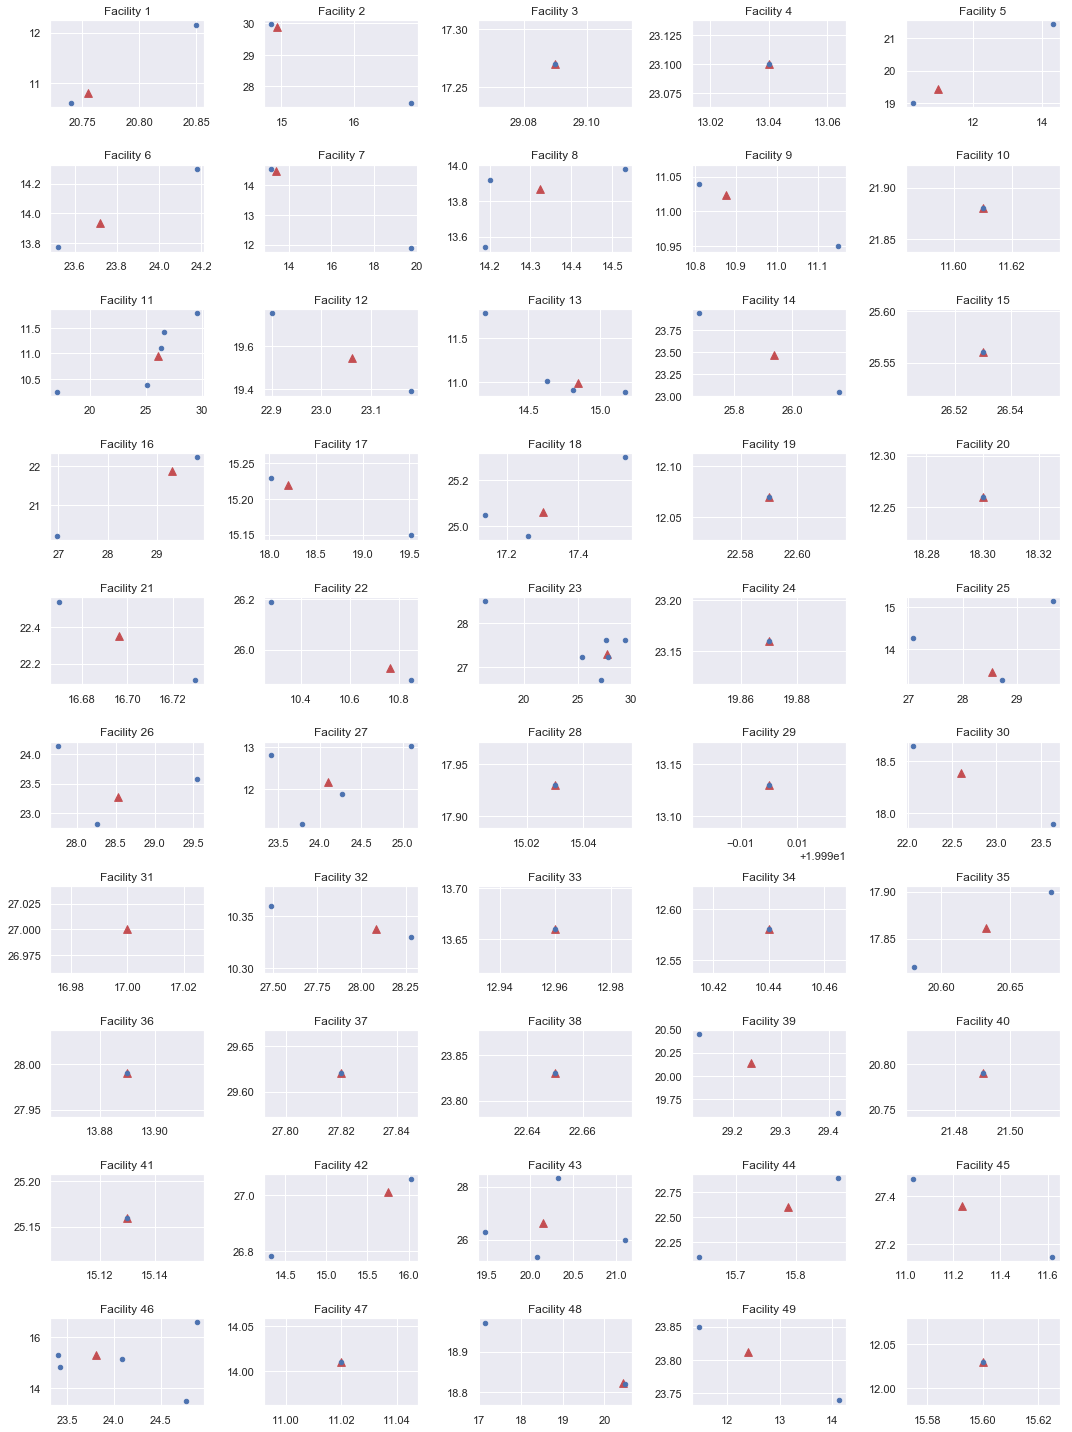

In [6]:
fig = plt.figure(figsize=(15,20))
for i in range(50):
    plt.title("Facility "+str(i))
    plt.subplot(10,5,i+1)
    plt.scatter(locations[i,0], locations[i,1], marker='^',c='r', s=60)
    plt.scatter(A[assigned_customers[i],0], A[assigned_customers[i],1],s=20)
    plt.tight_layout()

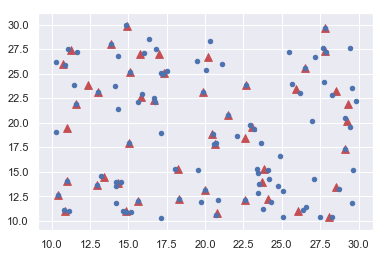

In [7]:
plt.scatter(locations[:,0], locations[:,1], marker='^',c='r', s=60)
plt.scatter(A[:,0], A[:,1],s=20)